In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf

import gym

from IPython.display import clear_output


In [2]:
class Policy(tf.keras.Model):
    '''
        Action space가 Continous인 경우는 Policy network의 Output을 다르게 설정해주어야 합니다.
        더 자세한 사항은 Sutton의 Chap.13 의 13.7을 참고하거나,
        해당 github의 2. ContinousREINFORCE 노트북 파일을 보시면 continous action space에 대해 다루었습니다. 
    '''
    def __init__(self, input_dim, action_dim, hidden):
        '''
            State  dimension: input_dim
            Action dimension: action_dim
        '''
        super(Policy, self).__init__()
        self.fc1 = tf.keras.layers.Dense(hidden, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.he_normal)
        self.fc2 = tf.keras.layers.Dense(action_dim, kernel_initializer=tf.keras.initializers.he_normal)
        self.sfm = tf.keras.layers.Softmax()
        
    def call(self, inputs):
        ''' 
            Input: State
            Output: Probability for each action. 
        '''
        return self.sfm(self.fc2(self.fc1(inputs)))

In [80]:
class Agent():
    def __init__(self, env, n_epi, max_steps, gamma, plot_freq, input_dim, action_dim, hidden, learning_rate, save_mode, model_name, saving_start_epi):
        # environment parameter
        self.gamma = gamma         # Reward의 Discount Rate 
        self.env = env             # 환경

        # trainig parameter
        self.n_epi = n_epi         # 학습을 시킬 총 episode 횟수
        self.max_steps = max_steps # 한 episode당 maximum step의 횟수.    
        self.plot_freq = plot_freq # plotting을 하는 주기
        self.frame_cnt = 0         # 매 스텝마다 1씩 추가되는 변수. total training frame을 카운트 하는 변수.

        # network paramter
        self.lr = learning_rate
        self.policy = Policy(input_dim, action_dim, hidden)
        self.optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        
        # log parameter
        self.scores = []
        self.losses = []
        self.avg = []
        self.save_mode = save_mode
        self.model_name = model_name
        self.saving_start = saving_start_epi
        
    def train(self):
        '''
            환경과 상호작용을 통해 agent를 학습시키는 함수. 위에서 정의되어진 함수들이 이곳에서 쓰입니다.
        '''
        self.scores = [] # plot을 위한 score 저장
        self.losses = [] # plot을 위한 loss 저장
        for i_episode in range(1, self.n_epi+1):
            with tf.GradientTape() as tape:
                epi_history = [] # agent의 행동에 의한 reward, log_probabilty 등을 저장. update network에서 쓰인다.
                rewards = [] 
                score = 0

                accum_R = 0  # 누적 reward를 계산하는 변수    
                loss = 0   
                epi_len = 0 # policy network을 update할 때, 앞에 gamma^t 부분을 계산하기 위한 변수입니다. 아래 gamma_powers 변수 참고.

                state = self.env.reset() # Get the initial state from the environment
                for step in range(self.max_steps):
                    state = tf.convert_to_tensor(state)
                    state = tf.expand_dims(state,axis=0)

                    prob_ = self.policy(state)
                    action = np.random.choice(np.squeeze(prob_).shape[0], p=np.squeeze(prob_))
    #                     action, log_prob, prob = self.select_action(state) # action을 선택 후 다음 줄에서 env에 넣어 환경으로 부터 feedback을 받습니다.
                    next_state, reward, done, _ = env.step(action)

                    epi_history.append([tf.math.log(prob_[0, action]), reward])  # update를 위한 reward와 log probabilty(= log(policy))를 저장
                    state = next_state
                    score += reward
                    self.frame_cnt += 1
                    if done: break
                
                epi_len = len(epi_history)
                for idx, [log_p, r] in enumerate(epi_history[::-1]):
                    accum_R = r + (self.gamma * accum_R)
                    gamma_pow_t = self.gamma**(epi_len-idx) # gamma^t
                    one_step_loss = -log_p * gamma_pow_t * accum_R  # sutton 책의 REINFORCE pseudo code 반영. Chapter.13.3
                    loss += one_step_loss
            
            grad = tape.gradient(loss,self.policy.trainable_variables)
            self.optimizer.apply_gradients(zip(grad, self.policy.trainable_variables))

            self.scores.append(score)
            self.losses.append(loss)
            if i_episode%self.plot_freq == 0: # 주기마다 plot.
                self._plot_status(i_episode, self.losses, self.scores)

            if self.save_mode & (i_episode > self.saving_start): self._save_model()
            self.avg.append(np.mean(self.scores[-10:]))
    
    def _save_model(self):
        
        last_mean = np.mean(self.scores[-10:])
        if  max(self.avg) < last_mean:
            self.policy.save_weights(self.model_name+f'Score_{round(last_mean, 3)}', save_format="tf")
            
    def _plot_status(self, i_episode, loss_hist, score_hist):
        subplot_params = [
            (121, f"Scores in episode_{i_episode}", score_hist),
            (122, f"Policy loss in episode:{i_episode}", loss_hist),
        ]

        clear_output(True)
        plt.figure(figsize=(10, 5), facecolor='w')
        for loc, title, values in subplot_params:
            plt.subplot(loc)
            plt.title(f'Frame:{self.frame_cnt} '+title)
            plt.plot(values)
        plt.show() 
        
    def test(self, model_path):
        ''' 저장된 pt파일을 불러와 test 합니다 '''
        
        self.policy.load_weights(model_path)
        
        state = self.env.reset()
        done = False
        score = 0
        accum_frames = []
        while not done:
            accum_frames.append(self.env.render(mode="rgb_array"))
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state,axis=0)

            prob_ = self.policy(state)
            action = np.random.choice(np.squeeze(prob_).shape[0], p=np.squeeze(prob_))
#                     action, log_prob, prob = self.select_action(state) # action을 선택 후 다음 줄에서 env에 넣어 환경으로 부터 feedback을 받습니다.
            next_state, reward, done, _ = env.step(action)
    
            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return accum_frames
        

In [84]:

env_name_list = ["CartPole-v0", "CartPole-v1", "MountainCar-v0", "LunarLander-v2"]
env_name = env_name_list[0]
env = gym.make(env_name)

# 몇 episode 이후부터 저장할 것인지 정하는 변수 입니다.
saving_start_epi = 100

# model을 저장할 폴더를 지정합니다. save_mode 변수로 저장 여부를 결정합니다.
save_mode = True
model_save_folder = './model_save'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
model_name = f"./{model_save_folder}/Discrete_REINFORCE_{env_name}_"

# env를 선언하고 state dimension과 action dimension을 뽑아오는 것. Gym Atari 환경에 한정된 코드.
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print("Environment: ", env_name)
print("State Dimension:", state_dim, " Action Dimension:", action_dim)

# 위에서 설명되었던 hyper parameter 설정. 가장 민감한 것은 learning rate이며, gamma도 학습에 영향을 크게 미칠때가 많습니다.
n_epi = 500
max_steps = 900
gamma = 0.99
plot_freq = 10

hidden = 32
learning_rate = 0.001

Environment:  CartPole-v0
State Dimension: 4  Action Dimension: 2


In [85]:
agent = Agent(
            env,
            n_epi,
            max_steps,
            gamma,
            plot_freq,
            state_dim,
            action_dim,
            hidden,
            learning_rate,
            save_mode,
            model_name,
            saving_start_epi) 

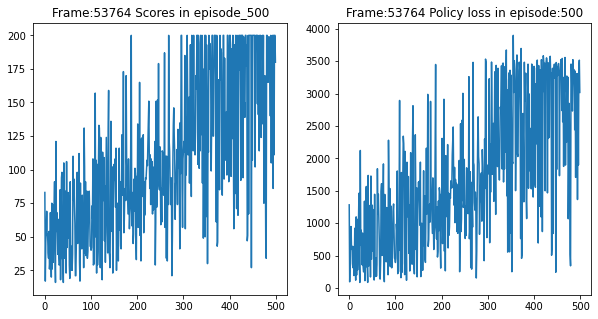

In [86]:
agent.train() 

In [98]:
# 모델을 test하고 게임 플레이한 결과를 배열로 저장합니다.

model_path = f"{model_save_folder}/Discrete_REINFORCE_CartPole-v0_Score_189.6"
frames = agent.test(model_path)

score:  200.0
